# Time Series Visualization

dataset: https://www.kaggle.com/jswicker/the-smell-of-fear

some plots: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
sns.set(rc={'figure.figsize':(11, 4)})

## Parsing

I need to parse the dates so I can use them as index. 

Examples: 
```
tof_df.loc['2013-12-18 14:00:00':'2013-12-18 16:41:00']
tof_df.loc['2013-12']
```

In [2]:
tof_file = '../data/datasets/the_smell_of_fear/TOF_CO2_data_30sec.csv'
tof_df = pd.read_csv(tof_file)

tof_df['time_parsed'] = pd.to_datetime(tof_df.Time, dayfirst=False)
tof_df['only_date'] = pd.to_datetime(tof_df['time_parsed'].dt.date)
tof_df = tof_df.set_index('time_parsed')

In [3]:
screening_times = '../data/datasets/the_smell_of_fear/screening_times.csv'
screening_df = pd.read_csv(screening_times)

screening_df['parsed_begin'] = pd.to_datetime(screening_df['begin'],dayfirst=True)

# Fix bad laveling
print(screening_df['movie'].unique())
screening_df['movie'] = screening_df['movie'].str.replace('Bele & Sebastian', 'Belle & Sebastian')
screening_df['movie'] = screening_df['movie'].str.replace('The Little Ghost', 'Little Ghost')
screening_df['movie'] = screening_df['movie'].str.replace('Little Ghost', 'The Little Ghost')

['Hobbit 2' 'Carrie' 'Wolkig 2' 'Suck Me Shakespeer' 'Dinosaurier'
 'Walter Mitty' 'Counselor' 'Belle & Sebastian' 'Bolshoi: Dornröschen'
 'Machete Kills' 'Buddy' 'The Hunger Games: Catching Fire'
 'Journey to the Christmas Star' 'Medicus' 'The Little Ghost'
 'Little Ghost' 'The Starving Games' 'Paranormal Activity'
 'Bele & Sebastian']


In [4]:
def get_the_duration(movie):
    movies_duration = {'Hobbit 2': 161, 'Carrie': 98, 'Wolkig 2': 96, 'Suck Me Shakespeer': 119, 'Dinosaurier': 82,
                       'Walter Mitty': 125, 'Counselor': 120, 'Belle & Sebastian': 104, 'Bolshoi: Dornröschen': 165,
                       'Machete Kills': 108, 'Buddy': 86, 'The Hunger Games: Catching Fire': 146,
                       'Journey to the Christmas Star': 80, 'Medicus': 150, 'The Little Ghost': 92,
                       'The Starving Games': 83, 'Paranormal Activity': 86
                       }
    return movies_duration[movie]
screening_df['movie_duration'] = screening_df['movie'].apply(get_the_duration)
screening_df['parsed_end'] = screening_df['parsed_begin'] + pd.to_timedelta(screening_df['movie_duration'], unit='m')

Fill the measures dataset with the movie information for the analysis


In [5]:
tof_df['number visitors'] = 0
tof_df['movie'] = 0
tof_df['filled %'] = 0
tof_df['sample index'] = 0
for index, row in screening_df.iterrows():
    begin = str(row['parsed_begin'])
    end = str(row['parsed_end'])    
    if not tof_df.loc[begin:end].shape[0]:
        continue
    tof_df.loc[begin:end,'number visitors'] = row['number visitors']
    tof_df.loc[begin:end, 'movie'] = row['movie']
    tof_df.loc[begin:end, 'filled %'] = row['filled %']
    tof_df.loc[begin:end, 'sample index'] = index + 1 


In [6]:
tof_df.head()

,Time,CO2,m14.0028,m15.0238,m15.9962,m16.0201,m17.0260,m18.0338,m18.9921,m18.9995,...,m371.0984,m372.0993,m373.0832,m374.0818,m375.0743,only_date,number visitors,movie,filled %,sample index
time_parsed,,,,,,,,,,,,,,,,,,,,,
2013-12-18 11:46:00,'12/18/2013 11:46:00',610.208,1.92631,3.97879,1.76990,0.969783,355.235,3908.58,NaN,NaN,...,0.288172,0.211790,0.182142,0.126824,NaN,2013-12-18,0,0,0.0,0
2013-12-18 11:46:30,'12/18/2013 11:46:30',609.304,1.90129,4.74365,1.81630,0.905811,359.527,3922.42,NaN,NaN,...,0.388942,0.184603,0.249867,0.133148,NaN,2013-12-18,0,0,0.0,0
2013-12-18 11:47:00,'12/18/2013 11:47:00',608.475,1.97128,4.72838,1.97672,0.843545,361.429,3929.61,NaN,NaN,...,0.373633,0.223074,0.198287,0.150358,NaN,2013-12-18,0,0,0.0,0
2013-12-18 11:47:30,'12/18/2013 11:47:30',607.667,1.78681,4.53120,1.83743,0.841400,358.413,3910.84,NaN,NaN,...,0.370601,0.180225,0.232600,0.091334,NaN,2013-12-18,0,0,0.0,0
2013-12-18 11:48:00,'12/18/2013 11:48:00',606.660,2.07051,4.71770,1.87686,0.984419,358.288,3919.43,NaN,NaN,...,0.375249,0.193158,0.205937,0.154501,NaN,2013-12-18,0,0,0.0,0


In [7]:
screening_df.head()

,scheduled,movie,OV,HFR,3D,begin,number visitors,filled %,screening room,capacity,parsed_begin,movie_duration,parsed_end
0,12-12-2013 14:00,Hobbit 2,NaN,NaN,NaN,12-12-2013 14:00,26,10.92,2,238,2013-12-12 14:00:00,161,2013-12-12 16:41:00
1,12-12-2013 19:00,Hobbit 2,NaN,NaN,NaN,12-12-2013 19:00,88,36.97,2,238,2013-12-12 19:00:00,161,2013-12-12 21:41:00
2,12-12-2013 23:20,Carrie,NaN,NaN,NaN,12-12-2013 23:20,21,8.82,2,238,2013-12-12 23:20:00,98,2013-12-13 00:58:00
3,13-12-2013 14:00,Hobbit 2,NaN,NaN,NaN,13-12-2013 14:00,6,2.52,2,238,2013-12-13 14:00:00,161,2013-12-13 16:41:00
4,13-12-2013 19:00,Hobbit 2,NaN,NaN,NaN,13-12-2013 19:00,162,68.07,2,238,2013-12-13 19:00:00,161,2013-12-13 21:41:00


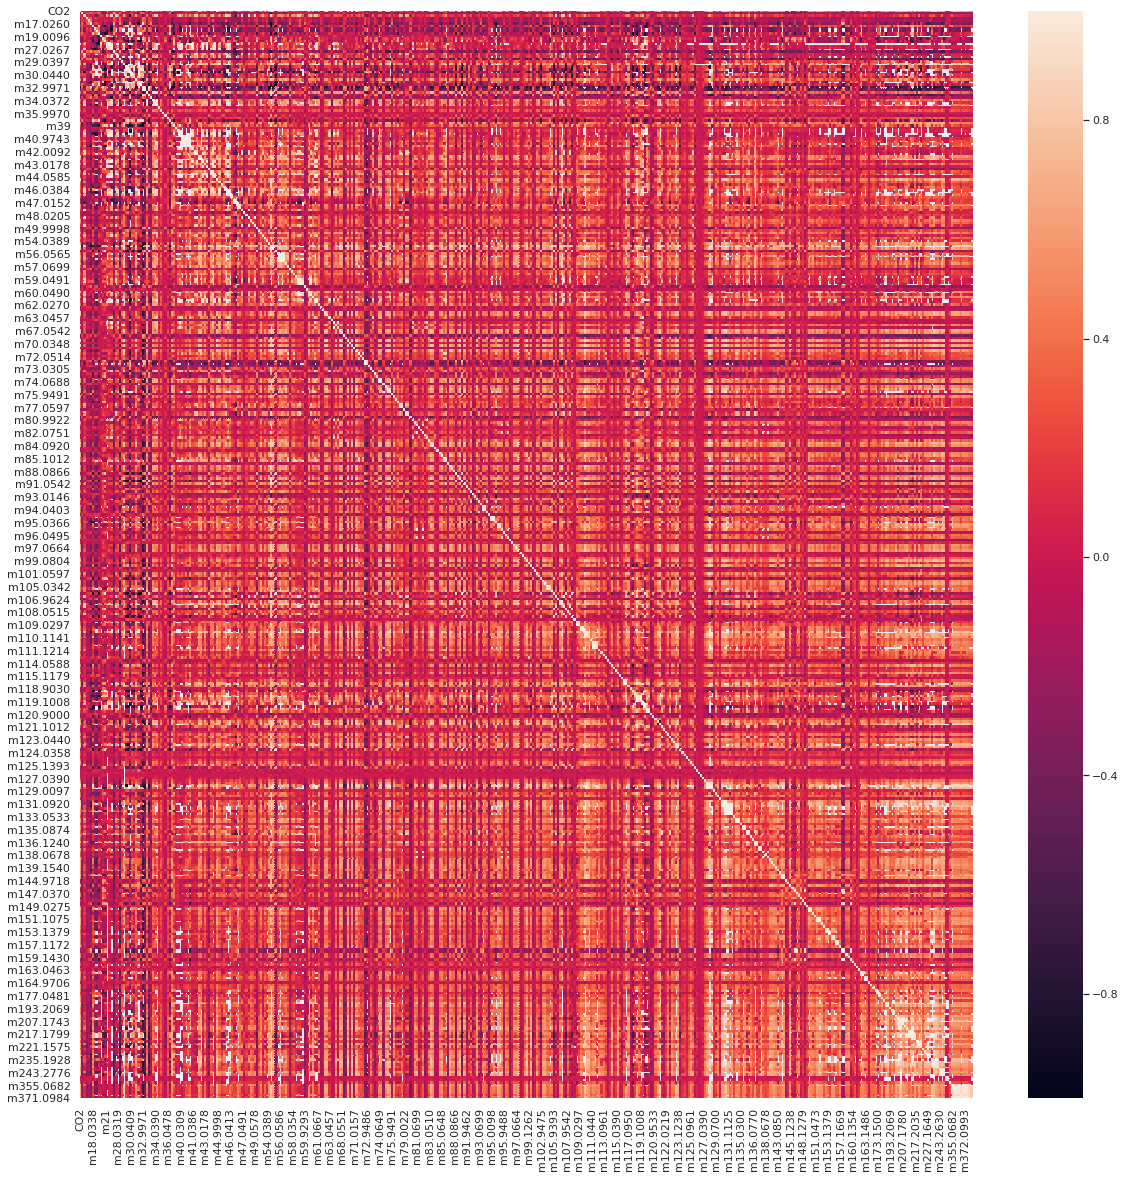

In [8]:
plt.figure(figsize=[20,20])
sns.heatmap(tof_df.iloc[:,1:431].corr())

## Analysis of the air

In [9]:
def plot_by_day(df,begin_date, end_date, target_columns):
    axes = df.loc[begin_date:end_date, target_columns].plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 3*len(target_columns)), subplots=True)
    for i,ax in enumerate(axes):
        ax.set_ylabel(target_columns[i])
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    
def plot_by_hour(df,begin_date, end_date, target_columns):
    axes = df.loc[begin_date:end_date, target_columns].plot(marker='.', alpha=0.5, linestyle='None',figsize=(20, 3*len(target_columns)),subplots=True)
    for i, ax in enumerate(axes):
        ax.set_ylabel(target_columns[i])
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:00'))

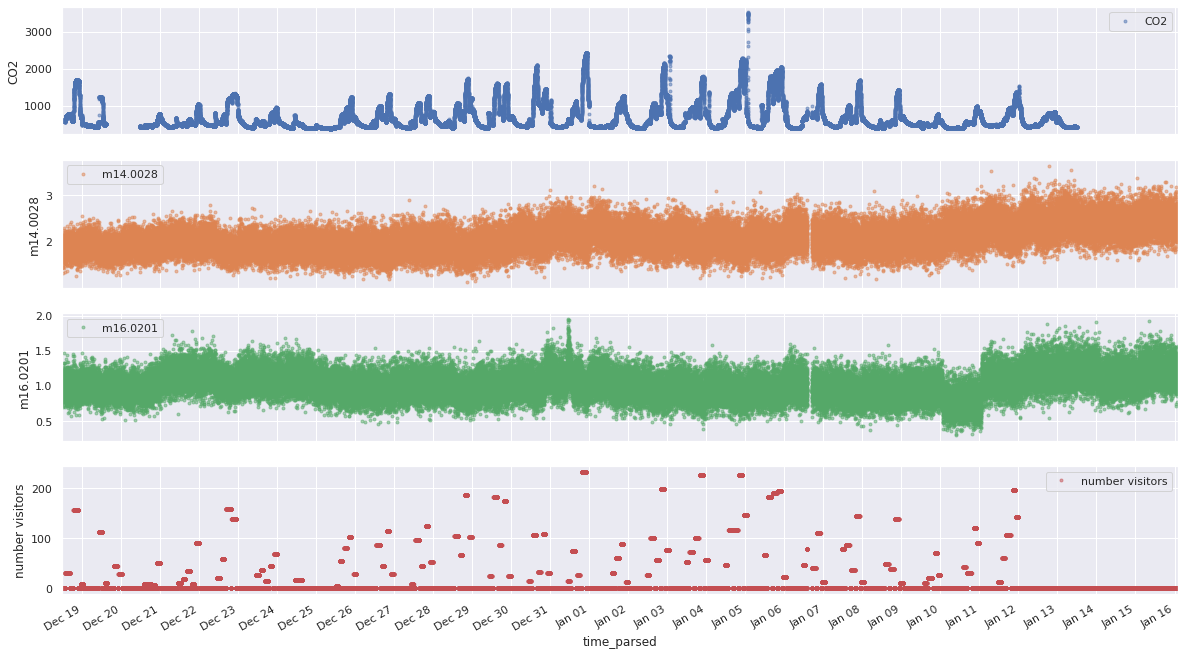

In [10]:
cols_plot = ['CO2', 'm14.0028', 'm16.0201','number visitors']
plot_by_day(tof_df, '2013-12-18','2014-01-16',cols_plot)

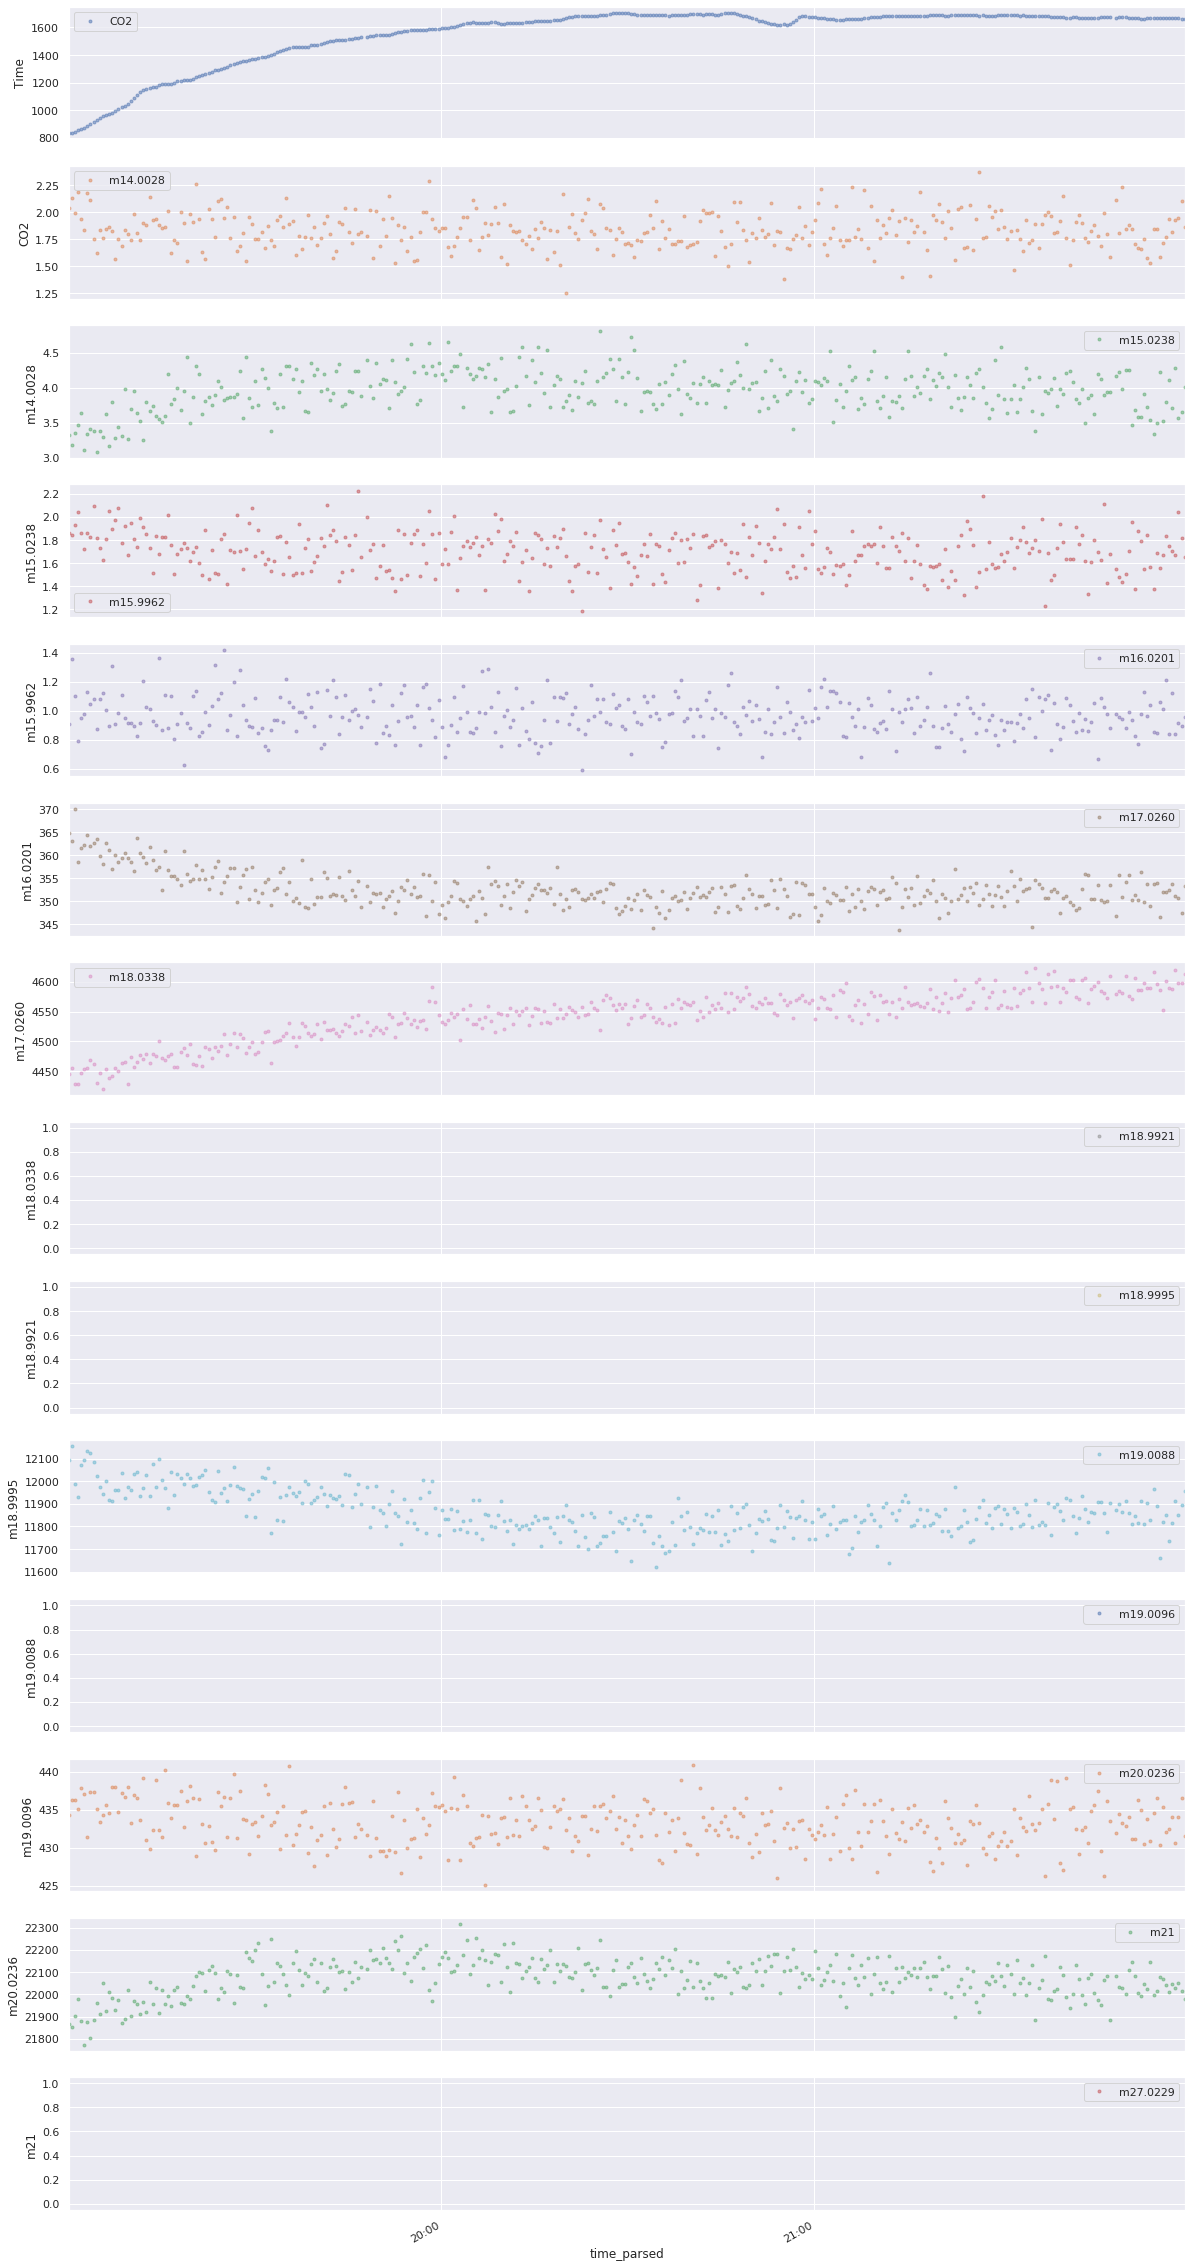

In [11]:
target_columns = ['CO2','m14.0028','number visitors']
plot_by_hour(tof_df,'2013-12-18 19:00:00', '2013-12-18 22:00:00',tof_df.columns[:15])


## Analysis of the movies

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

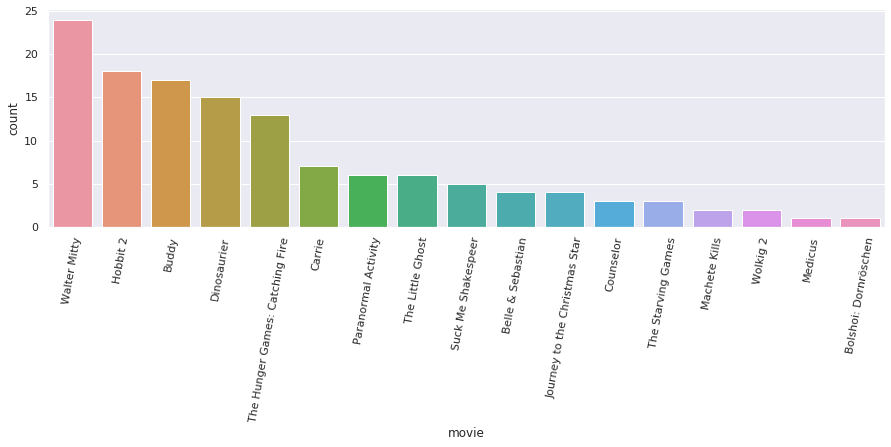

In [12]:
plt.figure(figsize=[15,4])
sns.countplot(data=screening_df, x='movie',order = screening_df['movie'].value_counts().index)
plt.xticks(rotation=80)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

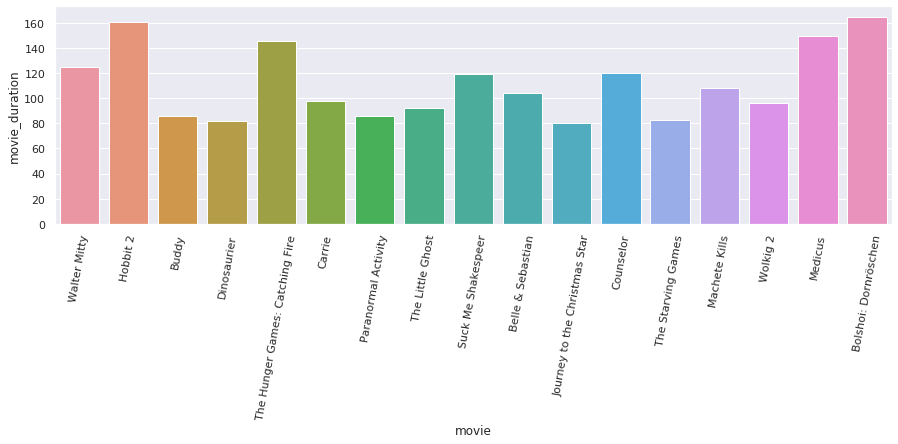

In [13]:
plt.figure(figsize=[15,4])
sns.barplot(data=screening_df, x='movie', y='movie_duration', order = screening_df['movie'].value_counts().index )
plt.xticks(rotation=80)

# Work in progress

In [14]:
def get_the_colors(movie):
    colors = ['#000000','#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600', '#003f5c',
              '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600','#008F7A']
    movies = [0,'Hobbit 2', 'Carrie', 'Wolkig 2', 'Suck Me Shakespeer', 'Dinosaurier', 'Walter Mitty', 'Counselor', 'Belle & Sebastian', 'Bolshoi: Dornröschen', 'Machete Kills', 'Buddy', 'The Hunger Games: Catching Fire', 'Journey to the Christmas Star', 'Medicus', 'The Little Ghost', 'The Starving Games', 'Paranormal Activity']
    movie_colors = dict(zip(movies,colors))
    return movie_colors[movie]

<Figure size 1440x288 with 0 Axes>

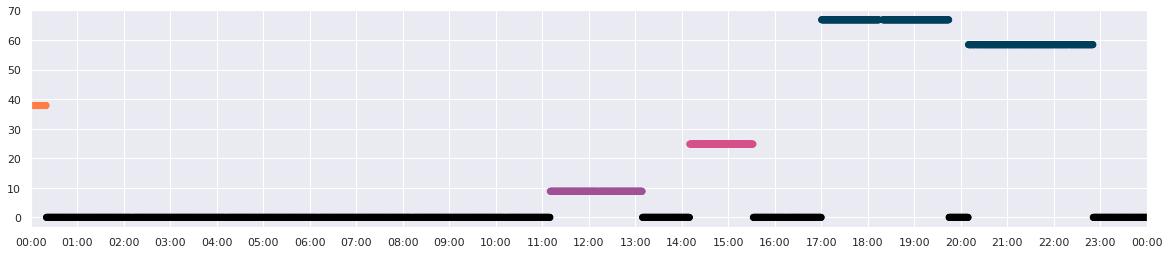

In [15]:
plt.figure(figsize=[20,4])

df_section = tof_df.loc['2013-12-22':'2013-12-23'].reset_index()

fig, ax = plt.subplots(figsize=[20,4])
ax.scatter(x= df_section['time_parsed'],y=df_section['filled %'],color=tof_df.loc['2013-12-22':'2013-12-23','movie'].apply(get_the_colors))
plt.xlim('2013-12-22','2013-12-23')
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:00'))

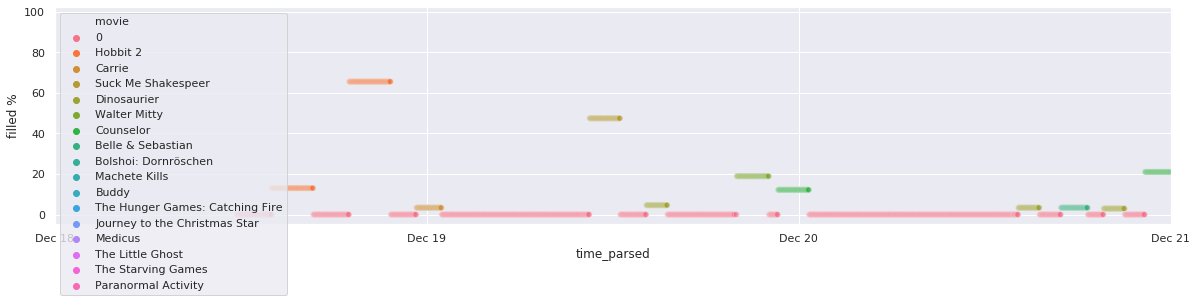

In [16]:
plt.figure(figsize=[20,4])

df_section = tof_df.loc['2013-12-22':'2013-12-23'].reset_index()

# fig, ax = plt.subplots()
ax = sns.scatterplot(data=tof_df.reset_index(),x='time_parsed',y='filled %', hue='movie',alpha=0.1)
plt.xlim('2013-12-18','2013-12-21')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [17]:
tof_df.movie.unique()

array([0, 'Hobbit 2', 'Carrie', 'Suck Me Shakespeer', 'Dinosaurier',
       'Walter Mitty', 'Counselor', 'Belle & Sebastian',
       'Bolshoi: Dornröschen', 'Machete Kills', 'Buddy',
       'The Hunger Games: Catching Fire', 'Journey to the Christmas Star',
       'Medicus', 'The Little Ghost', 'The Starving Games',
       'Paranormal Activity'], dtype=object)

# Transform the dataset into a supervised problem

I will select the sections of the data corresponding to the most common movies: Hobbit 2, Walter Mitty, Buddy, Hunger games and Dinosaurier. 

The samples of the new dataset will have 2 dimensions: 
* The time steps 
* The features

In [18]:
target_movies = ['Hobbit 2', 'Buddy', 'Walter Mitty', 'The Hunger Games: Catching Fire','Dinosaurier']

df_movies = tof_df.loc[tof_df['movie'].isin(target_movies),:]

df_movies

,Time,CO2,m14.0028,m15.0238,m15.9962,m16.0201,m17.0260,m18.0338,m18.9921,m18.9995,...,m371.0984,m372.0993,m373.0832,m374.0818,m375.0743,only_date,number visitors,movie,filled %,sample index
time_parsed,,,,,,,,,,,,,,,,,,,,,
2013-12-18 14:00:02,'12/18/2013 14:00:02',619.494,1.85029,3.17057,1.72606,1.039010,364.949,4254.93,NaN,NaN,...,0.415951,0.211048,0.228517,0.165493,NaN,2013-12-18,31,Hobbit 2,13.03,21
2013-12-18 14:00:32,'12/18/2013 14:00:32',620.278,1.61288,3.85020,1.72290,0.823970,361.499,4269.66,NaN,NaN,...,0.510154,0.270600,0.248050,0.166774,NaN,2013-12-18,31,Hobbit 2,13.03,21
2013-12-18 14:01:02,'12/18/2013 14:01:02',621.359,2.02692,3.96246,1.78672,1.210510,365.634,4271.77,NaN,NaN,...,0.465339,0.224658,0.297114,0.149893,NaN,2013-12-18,31,Hobbit 2,13.03,21
2013-12-18 14:01:32,'12/18/2013 14:01:32',622.780,2.08938,3.61794,2.03494,1.320790,369.164,4284.40,NaN,NaN,...,0.481612,0.231731,0.270819,0.109096,NaN,2013-12-18,31,Hobbit 2,13.03,21
2013-12-18 14:02:02,'12/18/2013 14:02:02',625.323,1.58202,3.69990,1.81779,1.101670,368.757,4277.96,NaN,NaN,...,0.538601,0.221212,0.268511,0.149329,NaN,2013-12-18,31,Hobbit 2,13.03,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-01-11 19:08:50,'01/11/2014 19:08:50',948.644,1.97780,2.58966,1.47155,1.152940,440.670,6128.27,1145.60,3210.19,...,0.521941,0.277859,0.324756,NaN,NaN,2014-01-11,107,Hobbit 2,47.13,129
2014-01-11 19:09:20,'01/11/2014 19:09:20',949.461,1.96742,2.83032,1.65951,0.835090,440.500,6123.63,1032.97,3268.68,...,0.418396,0.244416,0.211642,NaN,NaN,2014-01-11,107,Hobbit 2,47.13,129
2014-01-11 19:09:50,'01/11/2014 19:09:50',947.428,2.51630,2.62132,1.68251,1.183880,444.414,6111.18,1002.82,3238.48,...,0.488251,0.208942,0.275177,NaN,NaN,2014-01-11,107,Hobbit 2,47.13,129


In [19]:
def get_columns_with_too_much_nan(df,max_ratio=0.6):
    n_samples = df.shape[0]
    na_by_column = df.isna().sum()
    to_remove = []
    for column, n_nans in na_by_column.iteritems():
        nan_ratio = n_nans/n_samples
        if nan_ratio > max_ratio:
            to_remove.append(column)
    return to_remove
            
remove_columns = get_columns_with_too_much_nan(df_movies)
df_movies = df_movies.drop(columns=remove_columns)

In [20]:
print('Nan ratio: ',df_movies.isna().sum().sum() / (df_movies.shape[0] * df_movies.shape[1]))

Nan ratio:  0.07737853778122235


In [21]:
sample_indexes = df_movies['sample index'].unique()
print('We will have a total number of {} samples'.format(len(sample_indexes)))

We will have a total number of 74 samples


In [22]:
print(df_movies.columns[1:325])

Index(['CO2', 'm14.0028', 'm15.0238', 'm15.9962', 'm16.0201', 'm17.0260',
       'm18.0338', 'm19.0088', 'm20.0236', 'm21',
       ...
       'm243.2630', 'm327.0036', 'm355.0682', 'm355.0726', 'm356.0714',
       'm357.0682', 'm371.0984', 'm372.0993', 'm373.0832', 'm374.0818'],
      dtype='object', length=324)


In [23]:
movie_labels = []
movie_data = []
for index in sample_indexes:
    movie_label = df_movies.loc[df_movies['sample index']==index, 'movie'].unique()[0]
    print('Sample {}\nLabel: {}'.format(index, movie_label))
    data_sample = df_movies.loc[df_movies['sample index']==index,df_movies.columns[1:325]].fillna(-1, inplace=False).values
    print('Data shape: {}\n'.format( data_sample.shape))
    
    movie_labels.append(movie_label)
    movie_data.append(data_sample)

Sample 21
Label: Hobbit 2
Data shape: (321, 324)

Sample 22
Label: Hobbit 2
Data shape: (321, 324)

Sample 25
Label: Dinosaurier
Data shape: (164, 324)

Sample 26
Label: Walter Mitty
Data shape: (249, 324)

Sample 28
Label: Dinosaurier
Data shape: (164, 324)

Sample 30
Label: Dinosaurier
Data shape: (163, 324)

Sample 33
Label: Dinosaurier
Data shape: (164, 324)

Sample 35
Label: Dinosaurier
Data shape: (163, 324)

Sample 38
Label: Dinosaurier
Data shape: (163, 324)

Sample 40
Label: Hobbit 2
Data shape: (320, 324)

Sample 42
Label: Dinosaurier
Data shape: (163, 324)

Sample 47
Label: Dinosaurier
Data shape: (163, 324)

Sample 48
Label: Buddy
Data shape: (171, 324)

Sample 49
Label: Buddy
Data shape: (172, 324)

Sample 50
Label: Buddy
Data shape: (171, 324)

Sample 51
Label: Buddy
Data shape: (171, 324)

Sample 52
Label: Buddy
Data shape: (172, 324)

Sample 53
Label: The Hunger Games: Catching Fire
Data shape: (291, 324)

Sample 54
Label: Dinosaurier
Data shape: (164, 324)

Sample 55
L

In [24]:
for m in movie_data:
    print(m.shape)

(321, 324)
(321, 324)
(164, 324)
(249, 324)
(164, 324)
(163, 324)
(164, 324)
(163, 324)
(163, 324)
(320, 324)
(163, 324)
(163, 324)
(171, 324)
(172, 324)
(171, 324)
(171, 324)
(172, 324)
(291, 324)
(164, 324)
(171, 324)
(171, 324)
(291, 324)
(163, 324)
(171, 324)
(171, 324)
(291, 324)
(163, 324)
(172, 324)
(171, 324)
(291, 324)
(163, 324)
(172, 324)
(171, 324)
(291, 324)
(163, 324)
(172, 324)
(171, 324)
(290, 324)
(163, 324)
(164, 324)
(249, 324)
(172, 324)
(171, 324)
(291, 324)
(249, 324)
(249, 324)
(249, 324)
(291, 324)
(249, 324)
(249, 324)
(242, 324)
(290, 324)
(249, 324)
(249, 324)
(249, 324)
(290, 324)
(249, 324)
(249, 324)
(249, 324)
(43, 324)
(249, 324)
(249, 324)
(249, 324)
(291, 324)
(249, 324)
(249, 324)
(249, 324)
(291, 324)
(249, 324)
(249, 324)
(249, 324)
(320, 324)
(321, 324)
(321, 324)


In [32]:
padded_dataset =  pad_sequences(movie_data,dtype='float64')
np.save('../data/labels.npy',movie_labels)
np.save('../data/padded_sequences.npy', padded_dataset)

In [33]:
lab = np.load('../data/labels.npy')
mov = np.load('../data/padded_sequences.npy')

In [27]:
padded_dataset =  pad_sequences(movie_data,dtype='float64')

x_train, x_test, y_train, y_test = train_test_split(padded_dataset, movie_labels, test_size=0.2, random_state=42) 
x_train.shape, x_test.shape

(59, 321, 324)

In [37]:
len(target_movies)

5

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop, SGD
from keras.utils import np_utils

encoder = preprocessing.LabelEncoder()

y_train_c = encoder.fit_transform(y_train)
y_test_c = encoder.fit_transform(y_test)

In [27]:
neurons = 64
drop = 0.0
nlayers = 1  # >= 1
nclasses = len(target_movies)
impl = 2

y_train_c = np_utils.to_categorical(y_train_c, nclasses)
y_test_c = np_utils.to_categorical(y_test_c, nclasses)

model = Sequential()
model.add(LSTM(neurons, input_shape=(321, 324), implementation=impl, recurrent_dropout=drop))
model.add(Dense(nclasses))
model.add(Activation('softmax'))

optimizer = SGD(lr=0.01, momentum=0.95)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                99584     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 99,909
Trainable params: 99,909
Non-trainable params: 0
_________________________________________________________________


In [29]:
epochs = 500
batch_size = 1000
model.fit(x_train, y_train_c,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test_c), verbose=1)

Train on 59 samples, validate on 15 samples
Epoch 1/500
59/59 [==============================] - 1s 12ms/step - loss: 2.0998 - accuracy: 0.2712 - val_loss: 1.6969 - val_accuracy: 0.4000
Epoch 2/500
59/59 [==============================] - 0s 6ms/step - loss: 1.9427 - accuracy: 0.3051 - val_loss: 1.6502 - val_accuracy: 0.4000
Epoch 3/500
59/59 [==============================] - 0s 5ms/step - loss: 1.8885 - accuracy: 0.3051 - val_loss: 1.6333 - val_accuracy: 0.4000
Epoch 4/500
59/59 [==============================] - 0s 5ms/step - loss: 1.8320 - accuracy: 0.3051 - val_loss: 1.6139 - val_accuracy: 0.4000
Epoch 5/500
59/59 [==============================] - 0s 5ms/step - loss: 1.7535 - accuracy: 0.3220 - val_loss: 1.5963 - val_accuracy: 0.4000
Epoch 6/500
59/59 [==============================] - 0s 5ms/step - loss: 1.6783 - accuracy: 0.3220 - val_loss: 1.5772 - val_accuracy: 0.4000
Epoch 7/500
59/59 [==============================] - 0s 5ms/step - loss: 1.5526 - accuracy: 0.3220 - val_loss

Epoch 59/500
59/59 [==============================] - 0s 5ms/step - loss: 1.3529 - accuracy: 0.3220 - val_loss: 1.4504 - val_accuracy: 0.4000
Epoch 60/500
59/59 [==============================] - 0s 6ms/step - loss: 1.3483 - accuracy: 0.3390 - val_loss: 1.4498 - val_accuracy: 0.4000
Epoch 61/500
59/59 [==============================] - 0s 6ms/step - loss: 1.3425 - accuracy: 0.3390 - val_loss: 1.4501 - val_accuracy: 0.3333
Epoch 62/500
59/59 [==============================] - 0s 5ms/step - loss: 1.3362 - accuracy: 0.4576 - val_loss: 1.4517 - val_accuracy: 0.3333
Epoch 63/500
59/59 [==============================] - 0s 5ms/step - loss: 1.3304 - accuracy: 0.4237 - val_loss: 1.4545 - val_accuracy: 0.3333
Epoch 64/500
59/59 [==============================] - 0s 5ms/step - loss: 1.3258 - accuracy: 0.4237 - val_loss: 1.4585 - val_accuracy: 0.3333
Epoch 65/500
59/59 [==============================] - 0s 5ms/step - loss: 1.3229 - accuracy: 0.4237 - val_loss: 1.4632 - val_accuracy: 0.3333
Epoch 

Epoch 117/500
59/59 [==============================] - 0s 5ms/step - loss: 1.2486 - accuracy: 0.4576 - val_loss: 1.2958 - val_accuracy: 0.4000
Epoch 118/500
59/59 [==============================] - 0s 5ms/step - loss: 1.2471 - accuracy: 0.4576 - val_loss: 1.2952 - val_accuracy: 0.4000
Epoch 119/500
59/59 [==============================] - 0s 5ms/step - loss: 1.2457 - accuracy: 0.4576 - val_loss: 1.2945 - val_accuracy: 0.4000
Epoch 120/500
59/59 [==============================] - 0s 5ms/step - loss: 1.2445 - accuracy: 0.4576 - val_loss: 1.2936 - val_accuracy: 0.4000
Epoch 121/500
59/59 [==============================] - 0s 5ms/step - loss: 1.2432 - accuracy: 0.4576 - val_loss: 1.2924 - val_accuracy: 0.4000
Epoch 122/500
59/59 [==============================] - 0s 5ms/step - loss: 1.2420 - accuracy: 0.4576 - val_loss: 1.2907 - val_accuracy: 0.4000
Epoch 123/500
59/59 [==============================] - 0s 5ms/step - loss: 1.2408 - accuracy: 0.4576 - val_loss: 1.2884 - val_accuracy: 0.4000

Epoch 175/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1776 - accuracy: 0.4915 - val_loss: 1.1510 - val_accuracy: 0.4667
Epoch 176/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1767 - accuracy: 0.4915 - val_loss: 1.1488 - val_accuracy: 0.4667
Epoch 177/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1757 - accuracy: 0.4915 - val_loss: 1.1466 - val_accuracy: 0.4667
Epoch 178/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1748 - accuracy: 0.4915 - val_loss: 1.1443 - val_accuracy: 0.4667
Epoch 179/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1739 - accuracy: 0.4915 - val_loss: 1.1419 - val_accuracy: 0.4667
Epoch 180/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1729 - accuracy: 0.4915 - val_loss: 1.1396 - val_accuracy: 0.4667
Epoch 181/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1720 - accuracy: 0.4915 - val_loss: 1.1373 - val_accuracy: 0.4667

Epoch 233/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1382 - accuracy: 0.5085 - val_loss: 1.0729 - val_accuracy: 0.4667
Epoch 234/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1378 - accuracy: 0.5085 - val_loss: 1.0721 - val_accuracy: 0.4667
Epoch 235/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1373 - accuracy: 0.5085 - val_loss: 1.0714 - val_accuracy: 0.4667
Epoch 236/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1369 - accuracy: 0.5085 - val_loss: 1.0706 - val_accuracy: 0.4667
Epoch 237/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1365 - accuracy: 0.5085 - val_loss: 1.0700 - val_accuracy: 0.4667
Epoch 238/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1361 - accuracy: 0.5085 - val_loss: 1.0693 - val_accuracy: 0.4667
Epoch 239/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1356 - accuracy: 0.5085 - val_loss: 1.0687 - val_accuracy: 0.4667

Epoch 291/500
59/59 [==============================] - 0s 6ms/step - loss: 1.1195 - accuracy: 0.5085 - val_loss: 1.0410 - val_accuracy: 0.4667
Epoch 292/500
59/59 [==============================] - 0s 6ms/step - loss: 1.1192 - accuracy: 0.5085 - val_loss: 1.0407 - val_accuracy: 0.4667
Epoch 293/500
59/59 [==============================] - 0s 6ms/step - loss: 1.1190 - accuracy: 0.5085 - val_loss: 1.0403 - val_accuracy: 0.4667
Epoch 294/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1188 - accuracy: 0.5085 - val_loss: 1.0399 - val_accuracy: 0.4667
Epoch 295/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1186 - accuracy: 0.5085 - val_loss: 1.0395 - val_accuracy: 0.4667
Epoch 296/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1183 - accuracy: 0.5085 - val_loss: 1.0391 - val_accuracy: 0.4667
Epoch 297/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1181 - accuracy: 0.5085 - val_loss: 1.0387 - val_accuracy: 0.4667

Epoch 349/500
59/59 [==============================] - 0s 6ms/step - loss: 1.1186 - accuracy: 0.5085 - val_loss: 1.0446 - val_accuracy: 0.4667
Epoch 350/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1177 - accuracy: 0.5085 - val_loss: 1.0430 - val_accuracy: 0.4667
Epoch 351/500
59/59 [==============================] - 0s 6ms/step - loss: 1.1172 - accuracy: 0.5085 - val_loss: 1.0419 - val_accuracy: 0.4667
Epoch 352/500
59/59 [==============================] - 0s 6ms/step - loss: 1.1170 - accuracy: 0.5085 - val_loss: 1.0412 - val_accuracy: 0.4667
Epoch 353/500
59/59 [==============================] - 0s 6ms/step - loss: 1.1171 - accuracy: 0.5085 - val_loss: 1.0408 - val_accuracy: 0.4667
Epoch 354/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1175 - accuracy: 0.5085 - val_loss: 1.0407 - val_accuracy: 0.4667
Epoch 355/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1179 - accuracy: 0.5085 - val_loss: 1.0405 - val_accuracy: 0.4667

Epoch 407/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1088 - accuracy: 0.5085 - val_loss: 1.0171 - val_accuracy: 0.4667
Epoch 408/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1086 - accuracy: 0.5085 - val_loss: 1.0171 - val_accuracy: 0.4667
Epoch 409/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1085 - accuracy: 0.5085 - val_loss: 1.0171 - val_accuracy: 0.4667
Epoch 410/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1084 - accuracy: 0.5085 - val_loss: 1.0170 - val_accuracy: 0.4667
Epoch 411/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1084 - accuracy: 0.5085 - val_loss: 1.0168 - val_accuracy: 0.4667
Epoch 412/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1083 - accuracy: 0.5085 - val_loss: 1.0166 - val_accuracy: 0.4667
Epoch 413/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1082 - accuracy: 0.5085 - val_loss: 1.0164 - val_accuracy: 0.4667

Epoch 465/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1035 - accuracy: 0.5085 - val_loss: 1.0092 - val_accuracy: 0.4667
Epoch 466/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1034 - accuracy: 0.5085 - val_loss: 1.0091 - val_accuracy: 0.4667
Epoch 467/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1033 - accuracy: 0.5085 - val_loss: 1.0090 - val_accuracy: 0.4667
Epoch 468/500
59/59 [==============================] - 0s 5ms/step - loss: 1.1032 - accuracy: 0.5085 - val_loss: 1.0089 - val_accuracy: 0.4667
Epoch 469/500
59/59 [==============================] - 0s 6ms/step - loss: 1.1032 - accuracy: 0.5085 - val_loss: 1.0088 - val_accuracy: 0.4667
Epoch 470/500
59/59 [==============================] - 0s 6ms/step - loss: 1.1031 - accuracy: 0.5085 - val_loss: 1.0087 - val_accuracy: 0.4667
Epoch 471/500
59/59 [==============================] - 0s 6ms/step - loss: 1.1030 - accuracy: 0.5085 - val_loss: 1.0087 - val_accuracy: 0.4667